<a href="https://colab.research.google.com/github/Xzxleah/COMP6721/blob/main/%E2%80%9Ccomp6721_project_part2_ipynb%E2%80%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Setting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.optim import Adam

from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.datasets import ImageFolder, DatasetFolder

import matplotlib.pyplot as plt
from collections import Counter

import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks/comp6721')
directory_path = './'

# CNN model

In [ ]:
class CNN(nn.Module):  #CNN 
    def __init__(self, num_classes, first_pooling=True, deeper=False):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  
            nn.BatchNorm2d(64),
            nn.ReLU()   
            )  
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(64, 128, 5, 1, 1), 
            nn.BatchNorm2d(128),
            nn.ReLU()           
        )
        self.conv_layer2_without_pooling = nn.Sequential(
            nn.Conv2d(64, 128, 5, 2, 1), 
            nn.BatchNorm2d(128),
            nn.ReLU()           
        )
        self.pooling = nn.MaxPool2d(2, 2, 0)
        self.deeper_layer = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1), 
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU()    
        )
        out_channels = 256 if deeper else 128
        self.deeper = deeper
        self.first_pooling = first_pooling
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc_layer = nn.Sequential(nn.Linear(out_channels * 7 * 7, 250),
                        nn.Linear(250, num_classes))

    def forward(self, x):
        out = self.conv_layer1(x)
        if self.first_pooling:
          out = self.pooling(out)
          out = self.conv_layer2(out)
        else:
          out = self.conv_layer2_without_pooling(out)
        if self.deeper:
          out = self.pooling(out)
          out = self.deeper_layer(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        return self.fc_layer(out)

# Evaluation

In [ ]:
def evaluate_model(model, data_loader, show_matrix=True):
    model.to('cpu')
    predictions = torch.tensor([])
    targets = torch.tensor([])
    
    for i, (images, labels) in enumerate(data_loader):
        out = model(images)
        _, predicted = torch.max(out.data, 1)
        targets = torch.cat((targets, labels))
        predictions = torch.cat((predictions, predicted))

    accuracy = accuracy_score(targets, predictions) * 100
    f1 = f1_score(targets, predictions, average='macro')
    recall = recall_score(targets, predictions, average='macro')
    precision = precision_score(targets, predictions, average='macro')
    print('accuracy: %.2f%% f1 score: %.3f precision: %.3f recall: %.3f' % (accuracy, f1, precision, recall))
    conf_matrix = confusion_matrix(targets, predictions)
    if show_matrix:
      plt.figure(figsize=(10, 10))
      sns.heatmap(conf_matrix, xticklabels=class_names, yticklabels=class_names, annot=True, cmap='Blues');
    return conf_matrix,[accuracy, f1, recall, precision]

# Bias test

In [ ]:
def load_dataset_bias(directory_path, test_rate=0.25):
  image_transforms = transforms.Compose(
                    [
                     transforms.ToTensor(),
                     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                     transforms.Resize((128,128))
                    ])
  
  dataset = ImageFolder(
      root = directory_path,
      transform = image_transforms
      )
  return dataset

def show_examples(train_dataset):
  num_classes = len(train_dataset.classes)
  size_dataset = len(train_dataset)
  i = 0
  num_image_per_class = 4
  sample_idxs = []

  
  for j in range(num_classes):
    for k in range(num_image_per_class):
      random_num = random.randrange(size_dataset/num_classes)
      sample_idxs.append(i+random_num)
    i = i + int(size_dataset/num_classes)
  img = make_grid([train_dataset[idx][0] for idx in sample_idxs])
  img = img / 2 + 0.5
  plt.figure(figsize=(20, 20))
  plt.imshow(np.transpose(img, (1, 2, 0)))
  plt.axis('off')

In [ ]:
class_names = os.listdir(directory_path + '/mask_dataset/')
class_names.sort()
num_classes = len(class_names)

In [ ]:
deeper_CNN = CNN(5, False, True)
deeper_CNN.load_state_dict(torch.load('deeper-CNN-model.pt'))

<All keys matched successfully>

## Load female and male test data

In [ ]:
batch_size = 500
folder_name = './mask_dataset_bias/gender/female(5_100)/'
test_set_female = load_dataset_bias(folder_name)
test_loader_female = DataLoader(test_set_female, batch_size=batch_size, shuffle=False, drop_last=False)

folder_name = './mask_dataset_bias/gender/male(5_100)/'
test_set_male = load_dataset_bias(folder_name)
test_loader_male = DataLoader(test_set_male, batch_size=batch_size, shuffle=False, drop_last=False)


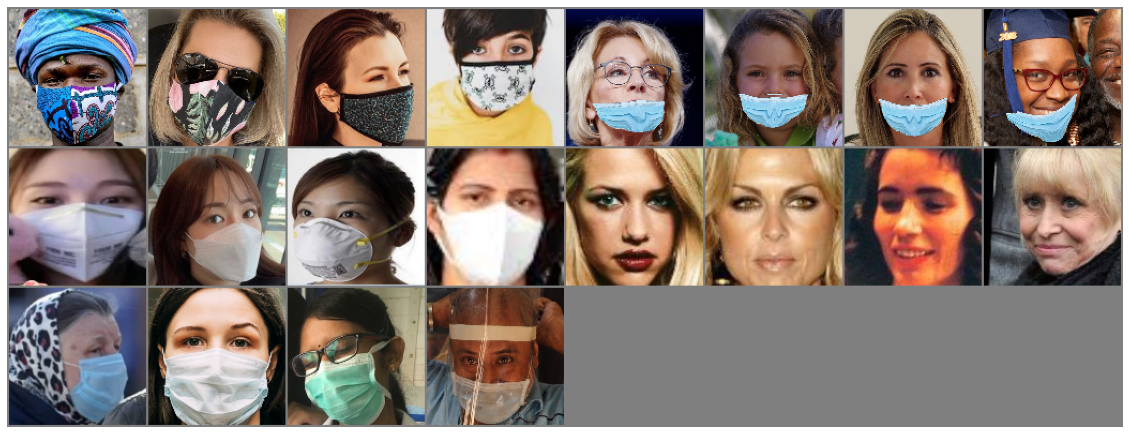

In [ ]:
show_examples(test_set_female)

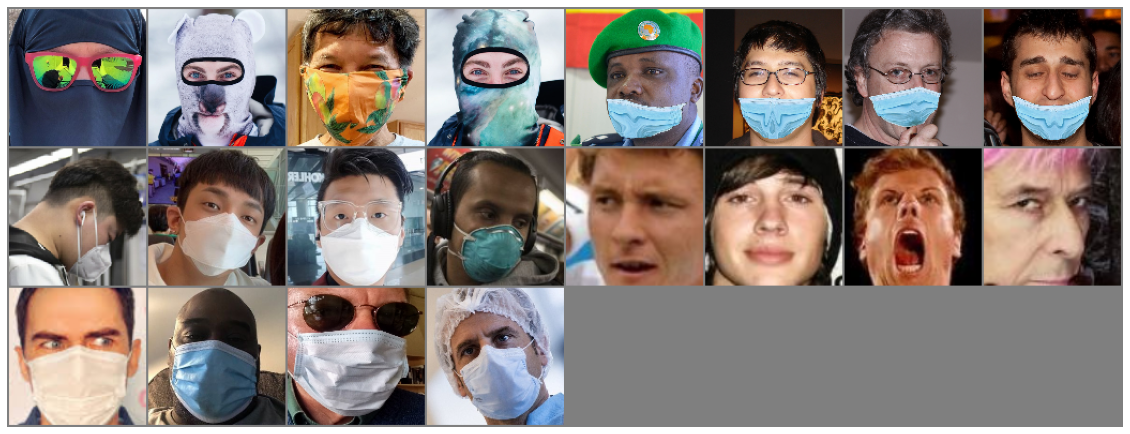

In [ ]:
show_examples(test_set_male)

### evaluation for female and male

accuracy: 83.20% f1 score: 0.831 precision: 0.833 recall: 0.832


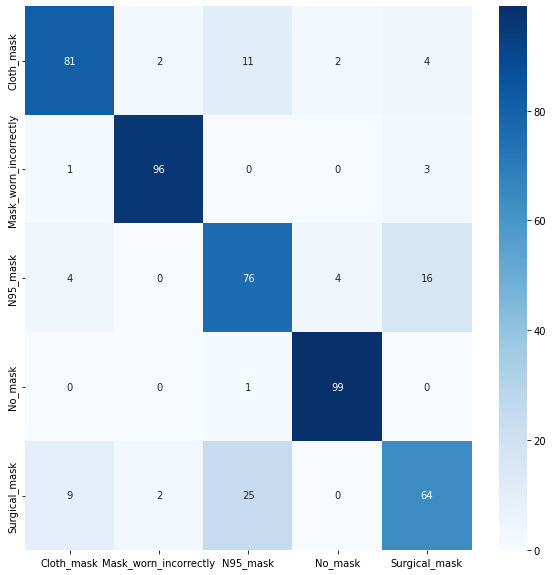

In [ ]:
evaluate_model(deeper_CNN, test_loader_female);

accuracy: 82.80% f1 score: 0.829 precision: 0.832 recall: 0.828


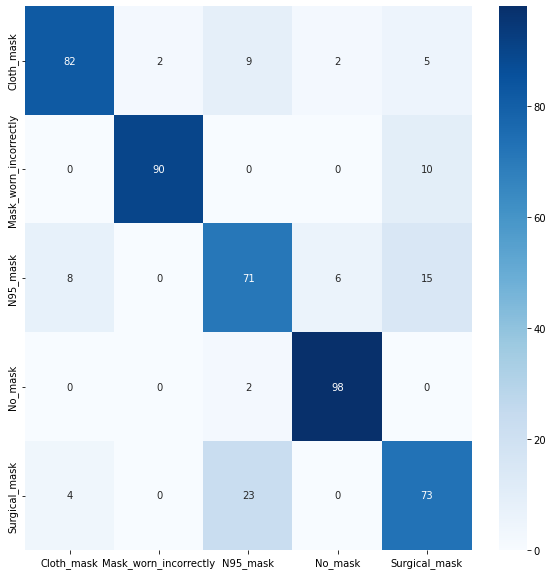

In [ ]:
evaluate_model(deeper_CNN, test_loader_male);

## Load age groups data

In [ ]:
folder_name = './mask_dataset_bias/age(100+50+50)/adult(5_100)/'
test_set_adult = load_dataset_bias(folder_name)
test_loader_adult = DataLoader(test_set_adult, batch_size=batch_size, shuffle=False, drop_last=False)

folder_name = './mask_dataset_bias/age(100+50+50)/child(5_50)/'
test_set_child = load_dataset_bias(folder_name)
test_loader_child = DataLoader(test_set_child, batch_size=batch_size, shuffle=False, drop_last=False)

folder_name = './mask_dataset_bias/age(100+50+50)/old(5_50)/'
test_set_old = load_dataset_bias(folder_name)
test_loader_old = DataLoader(test_set_old, batch_size=batch_size, shuffle=False, drop_last=False)

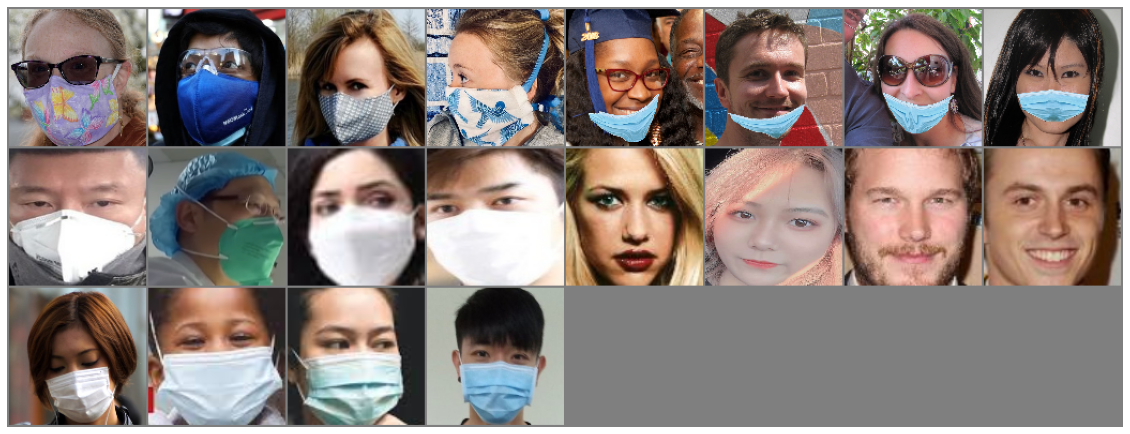

In [ ]:
show_examples(test_set_adult)

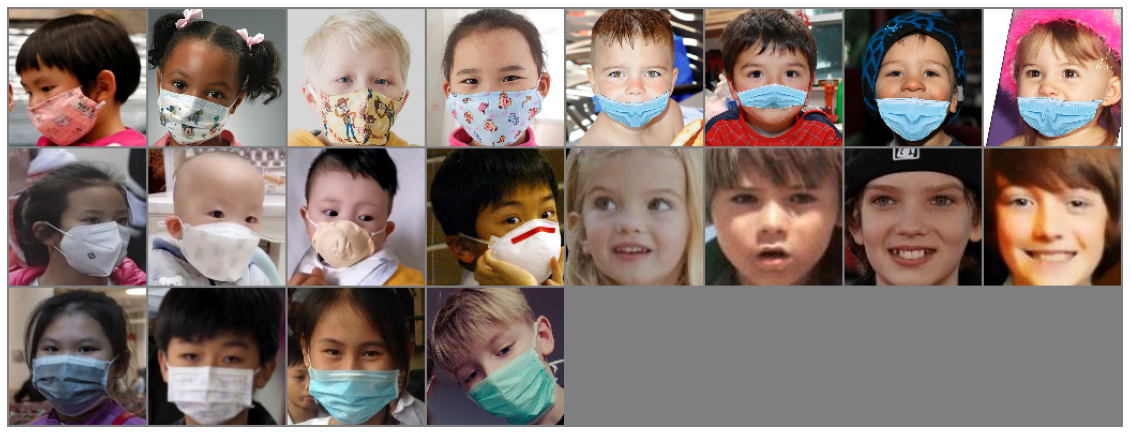

In [ ]:
show_examples(test_set_child)

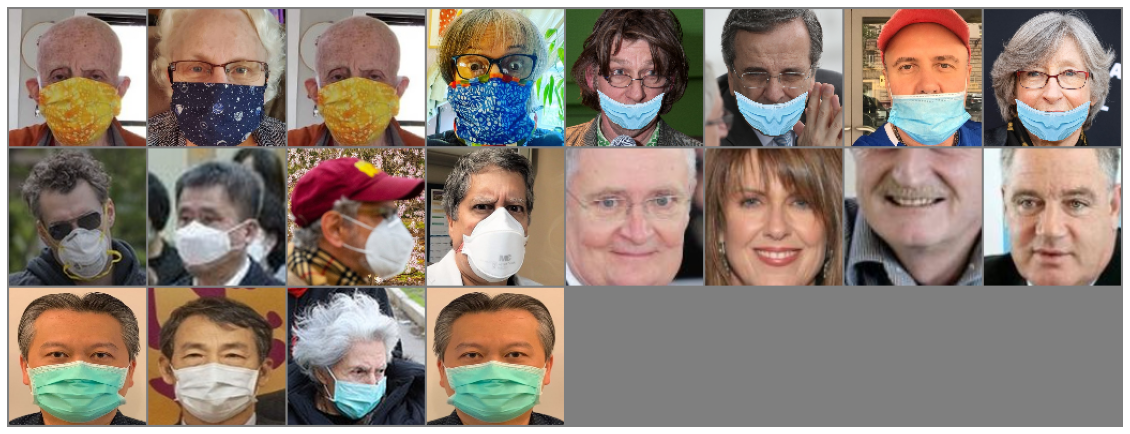

In [ ]:
show_examples(test_set_old)

### evaluation for child, adult and old age groups

accuracy: 70.00% f1 score: 0.699 precision: 0.715 recall: 0.700


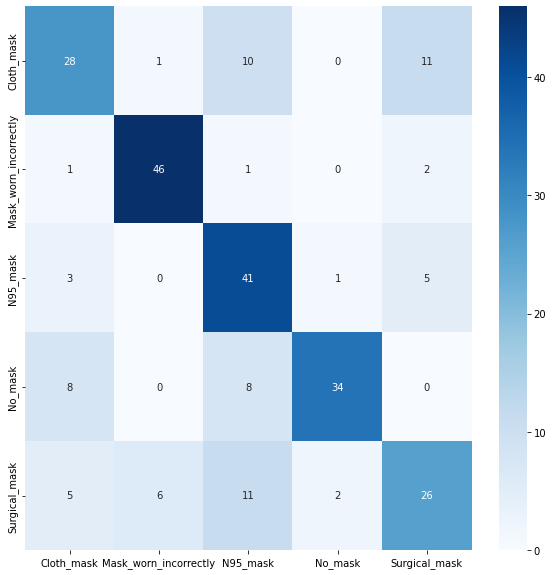

In [ ]:
evaluate_model(deeper_CNN, test_loader_child);

accuracy: 84.60% f1 score: 0.845 precision: 0.850 recall: 0.846


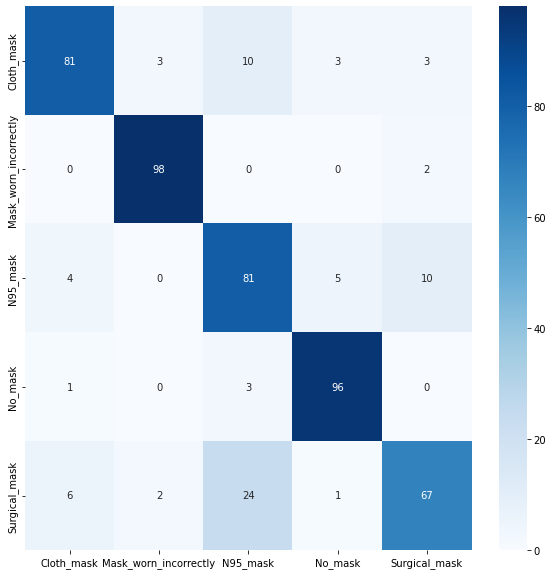

In [ ]:
evaluate_model(deeper_CNN, test_loader_adult);

accuracy: 82.00% f1 score: 0.821 precision: 0.824 recall: 0.820


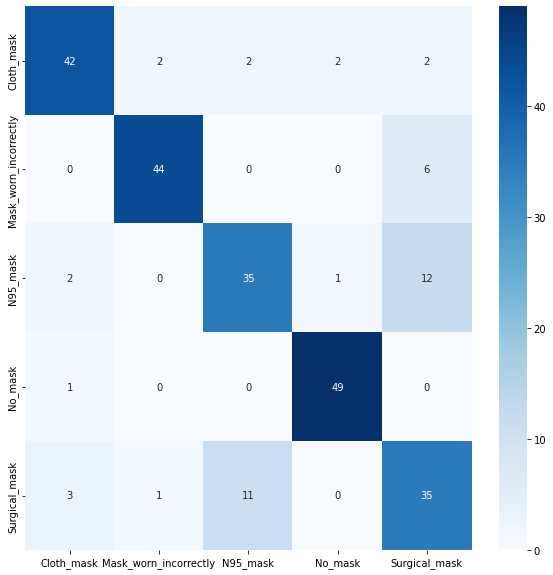

In [ ]:
evaluate_model(deeper_CNN, test_loader_old);

# Retrain model with new dataset

# Loading dataset

In [ ]:
def load_dataset(directory_path, test_rate=0.25):
  image_transforms = transforms.Compose(
                    [
                     transforms.ToTensor(),
                     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                     transforms.Resize((128,128))
                    ])
  
  dataset = ImageFolder(
                        root = directory_path,
                        transform = image_transforms
                        )
  train_set, test_set = torch.utils.data.random_split(dataset, [1500, 500])
  return dataset, train_set, test_set

In [ ]:
dataset, train_set, test_set = load_dataset(directory_path + '/new_mask_dataset/mask_dataset_re')
print('Total number of images in training dataset: ',len(train_set))
print('Total number of images in testing dataset: ', len(test_set))

dataset_idxs = np.arange(len(dataset))

train_idxs = train_set.indices

test_idxs = test_set.indices

train_labels = np.array(dataset.targets)[train_idxs]
test_labels = np.array(dataset.targets)[test_idxs]
labels = np.array(dataset.targets)[dataset_idxs]

Total number of images in training dataset:  1500
Total number of images in testing dataset:  500


In [ ]:
class_names = os.listdir(directory_path + '/mask_dataset/')
class_names.sort()
num_classes = len(class_names)
print(class_names)

['Cloth_mask', 'Mask_worn_incorrectly', 'N95_mask', 'No_mask', 'Surgical_mask']


# Training

In [ ]:
def train(model, train_loader, lr, num_epoch, model_name):
    model.to(device)
    total_step = len(train_loader)
    optimizer = Adam(model.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    stat = np.array([])
    for epoch in range(num_epoch):
        for i, (images, labels) in enumerate(train_loader):
            #print(images)
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            l = loss(outputs, labels)

            optimizer.zero_grad()
            l.backward()
            optimizer.step()

            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            
            loss_val = l.item()
            acc_val = (correct / total) * 100
            
            print(f'Epoch [{epoch + 1}/{num_epoch}], Step [{i + 1}/{total_step}], Loss: {l.item():.4f}, Accuracy: {(correct / total) * 100:.2f}')

            stat = np.append(stat, (correct / total) * 100)
    torch.save(model.state_dict(), f'./{model_name}-model.pt')
    return stat

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

batch_size = 500
num_epoch = 5
lr = 0.0001

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)

cuda


In [ ]:
deeper_CNN = CNN(5, False, True)
train(deeper_CNN, train_loader, lr, num_epoch, 'deeper-CNN-unbias');

Epoch [1/5], Step [1/3], Loss: 1.6437, Accuracy: 15.40
Epoch [1/5], Step [2/3], Loss: 1.2968, Accuracy: 53.60
Epoch [1/5], Step [3/3], Loss: 1.1166, Accuracy: 56.80
Epoch [2/5], Step [1/3], Loss: 0.9301, Accuracy: 62.80
Epoch [2/5], Step [2/3], Loss: 0.8644, Accuracy: 70.60
Epoch [2/5], Step [3/3], Loss: 0.8068, Accuracy: 68.40
Epoch [3/5], Step [1/3], Loss: 0.6950, Accuracy: 75.00
Epoch [3/5], Step [2/3], Loss: 0.6770, Accuracy: 76.20
Epoch [3/5], Step [3/3], Loss: 0.6601, Accuracy: 78.20
Epoch [4/5], Step [1/3], Loss: 0.5447, Accuracy: 80.00
Epoch [4/5], Step [2/3], Loss: 0.6319, Accuracy: 77.00
Epoch [4/5], Step [3/3], Loss: 0.5954, Accuracy: 78.60
Epoch [5/5], Step [1/3], Loss: 0.5319, Accuracy: 81.80
Epoch [5/5], Step [2/3], Loss: 0.5700, Accuracy: 80.00
Epoch [5/5], Step [3/3], Loss: 0.4810, Accuracy: 82.80


accuracy: 79.60% f1 score: 0.796 precision: 0.809 recall: 0.793


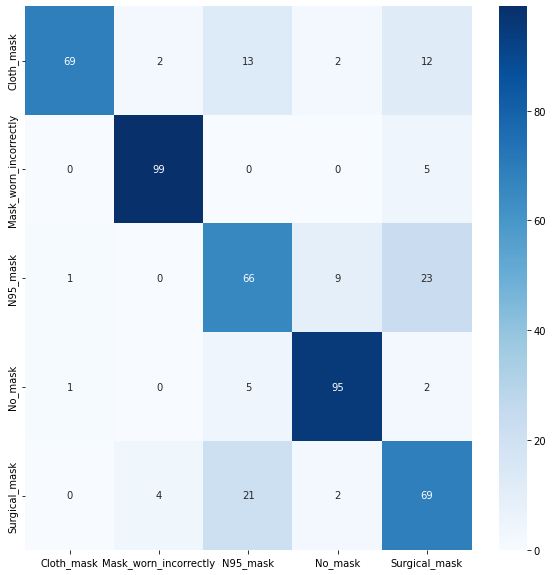

In [ ]:
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False)
evaluate_model(deeper_CNN, test_loader);

# Re-evaluate bias

### evaluation for female and male

accuracy: 82.80% f1 score: 0.828 precision: 0.834 recall: 0.828


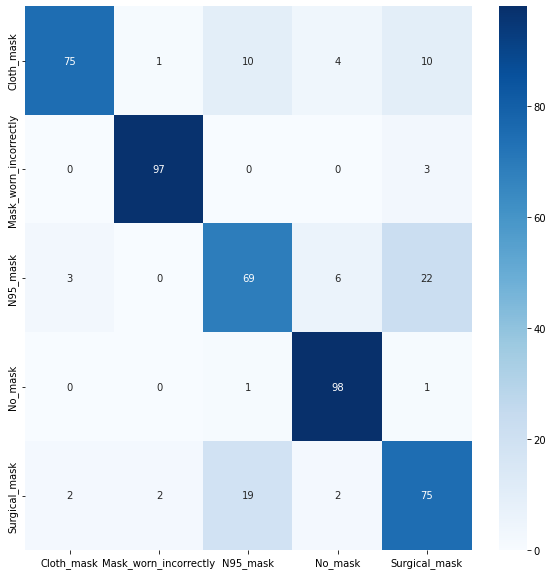

In [ ]:
evaluate_model(deeper_CNN, test_loader_female);

accuracy: 81.20% f1 score: 0.813 precision: 0.824 recall: 0.812


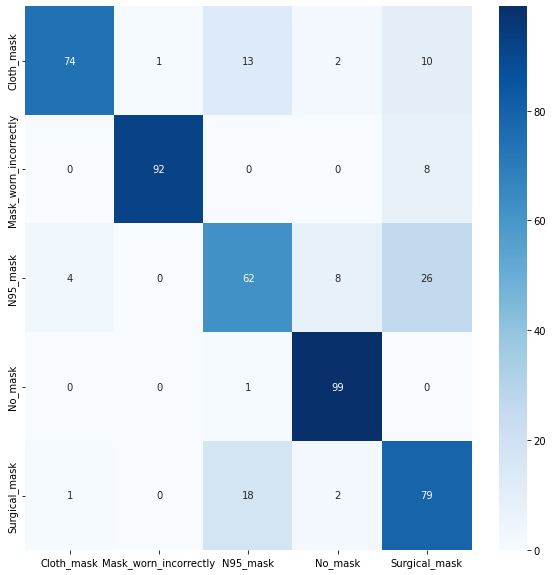

In [ ]:
evaluate_model(deeper_CNN, test_loader_male);

### evaluation for child, adult and old age groups

accuracy: 72.80% f1 score: 0.728 precision: 0.741 recall: 0.728


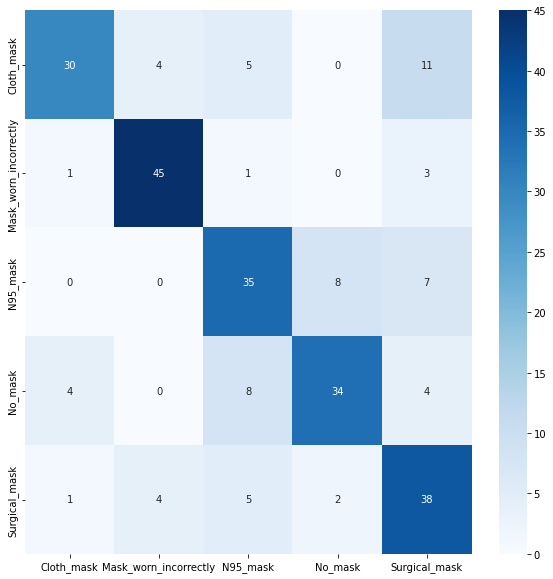

In [ ]:
evaluate_model(deeper_CNN, test_loader_child);

accuracy: 81.40% f1 score: 0.814 precision: 0.824 recall: 0.814


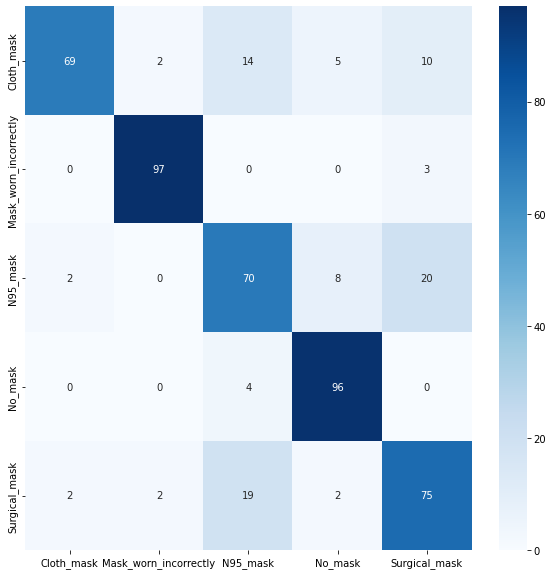

In [ ]:
evaluate_model(deeper_CNN, test_loader_adult);

accuracy: 86.00% f1 score: 0.861 precision: 0.867 recall: 0.860


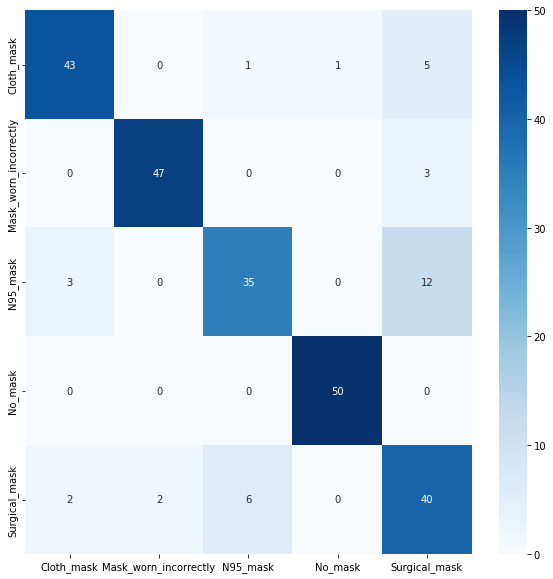

In [ ]:
evaluate_model(deeper_CNN, test_loader_old);

# K-fold

In [ ]:
num_folds = 10

In [ ]:
def plot_numerical_arrays(num_arrays=[], labels=[], xlabel='', ylabel='', title=''):
    plt.figure(figsize=(10, 5))
    if len(num_arrays) != len(labels):
        raise Exception("length of numerical arrays should be same as length of labels")
    num_len = len(num_arrays)
    for i in range(num_len):
        plt.plot(num_arrays[i], label=labels[i])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
def run_kfold(model, dataset, num_folds, batch_size, num_epoch, model_name):
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True)
    loss = nn.CrossEntropyLoss()
    total_scores = []
    stats = []
    confusion_matrixs = []
    train_idxs = dataset_idxs = np.arange(len(dataset))
    train_labels = np.array(dataset.targets)[train_idxs]

    # iterate over each fold
    for k_fold_num, (train_index, test_index) in enumerate(kf.split(train_idxs, train_labels)):
        model.to(device) # push training to either GPU/CPU
        
        print('Running K-Fold cross-validation on fold-', k_fold_num + 1)
        
        train_fold = Subset(dataset, train_idxs[train_index])
        test_fold = Subset(dataset, train_idxs[test_index])

        train_loader = DataLoader(train_fold, batch_size=batch_size, shuffle=True, drop_last=False)
        test_loader = DataLoader(test_fold, batch_size=batch_size, shuffle=True, drop_last=False)
        total_step = len(train_loader)

        # run training
        stat = train(model, train_loader, lr, num_epoch, model_name + '_fold_' + str(k_fold_num))

        stats.append(stat)
        # run evaluation on validation fold
        print('validation result: ') 
        conf_matrix, scores = evaluate_model(model,test_loader, False)
        scores.insert(0, 'fold-' + str(k_fold_num))
        confusion_matrixs.append(conf_matrix)
        total_scores.append(scores)
        
        
        # reset model parameters when going to the next fold
        if k_fold_num != num_folds - 1:
            model = model.__class__(5, False, True)
            
    scores_df = pd.DataFrame(total_scores, columns=['label', 'accuracy', 'f1', 'recall', 'precision'])

    return stats, scores_df, confusion_matrixs

## Kfold on prev dataset

In [ ]:
deeper_CNN = CNN(5, False, True)
dataset, train_set, test_set = load_dataset(directory_path + '/mask_dataset')
stats, scores_df, confusion_matrixs = run_kfold(deeper_CNN, dataset, num_folds, batch_size, num_epoch, 'deeper-cnn-bias')

Running K-Fold cross-validation on fold- 1
Epoch [1/5], Step [1/4], Loss: 1.6266, Accuracy: 17.40
Epoch [1/5], Step [2/4], Loss: 1.4776, Accuracy: 35.00
Epoch [1/5], Step [3/4], Loss: 1.1270, Accuracy: 51.00
Epoch [1/5], Step [4/4], Loss: 1.0830, Accuracy: 52.33
Epoch [2/5], Step [1/4], Loss: 1.0246, Accuracy: 57.20
Epoch [2/5], Step [2/4], Loss: 0.7584, Accuracy: 76.60
Epoch [2/5], Step [3/4], Loss: 0.6926, Accuracy: 73.60
Epoch [2/5], Step [4/4], Loss: 0.7180, Accuracy: 75.33
Epoch [3/5], Step [1/4], Loss: 0.7055, Accuracy: 72.80
Epoch [3/5], Step [2/4], Loss: 0.6342, Accuracy: 76.40
Epoch [3/5], Step [3/4], Loss: 0.5925, Accuracy: 80.20
Epoch [3/5], Step [4/4], Loss: 0.5745, Accuracy: 78.33
Epoch [4/5], Step [1/4], Loss: 0.5309, Accuracy: 79.40
Epoch [4/5], Step [2/4], Loss: 0.5146, Accuracy: 81.00
Epoch [4/5], Step [3/4], Loss: 0.5326, Accuracy: 83.60
Epoch [4/5], Step [4/4], Loss: 0.5445, Accuracy: 80.67
Epoch [5/5], Step [1/4], Loss: 0.4823, Accuracy: 82.40
Epoch [5/5], Step [2/4

training accuracy

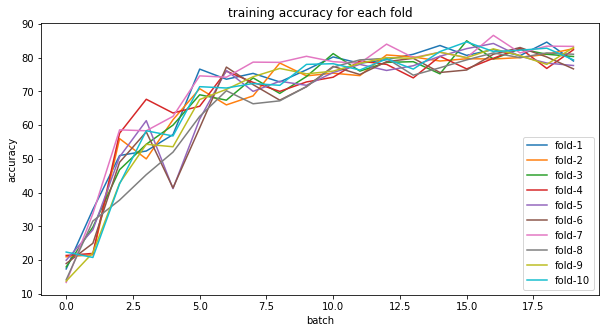

In [ ]:
plot_numerical_arrays(stats, ['fold-'+str(i+1) for i in range(num_folds)], 'batch', 'accuracy', 'training accuracy for each fold')

evaluation

In [ ]:
min_row = pd.DataFrame.min(scores_df)
min_row['label'] = 'min'
max_row = pd.DataFrame.max(scores_df)
max_row['label'] = 'max'
avg_row = pd.DataFrame.mean(scores_df)
avg_row['label'] = 'avg'
scores_df = scores_df.append(min_row, ignore_index=True)
scores_df = scores_df.append(max_row, ignore_index=True)
scores_df = scores_df.append(avg_row, ignore_index=True)
print(scores_df)

     label  accuracy        f1  recall  precision
0   fold-0      80.5  0.802528   0.805   0.814730
1   fold-1      80.5  0.802155   0.805   0.802073
2   fold-2      81.0  0.810778   0.810   0.812278
3   fold-3      77.5  0.767173   0.775   0.781740
4   fold-4      84.0  0.837518   0.840   0.838993
5   fold-5      78.5  0.782428   0.785   0.785856
6   fold-6      80.0  0.802856   0.800   0.814159
7   fold-7      79.0  0.791516   0.790   0.800266
8   fold-8      81.0  0.808135   0.810   0.811092
9   fold-9      80.0  0.796688   0.800   0.805415
10     min      77.5  0.767173   0.775   0.781740
11     max      84.0  0.837518   0.840   0.838993
12     avg      80.2  0.800178   0.802   0.806660


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """


## Kfold on unbias dataset

In [ ]:
deeper_CNN = CNN(5, False, True) 
dataset, train_set, test_set = load_dataset(directory_path + '/new_mask_dataset/mask_dataset_re') 
stats, scores_df, confusion_matrixs = run_kfold(deeper_CNN, dataset, num_folds, batch_size, num_epoch, 'deeper-cnn-unbias')

Running K-Fold cross-validation on fold- 1
Epoch [1/5], Step [1/4], Loss: 1.6194, Accuracy: 22.20
Epoch [1/5], Step [2/4], Loss: 1.5894, Accuracy: 34.80
Epoch [1/5], Step [3/4], Loss: 1.1802, Accuracy: 48.20
Epoch [1/5], Step [4/4], Loss: 1.0142, Accuracy: 61.33
Epoch [2/5], Step [1/4], Loss: 0.9534, Accuracy: 63.80
Epoch [2/5], Step [2/4], Loss: 0.8231, Accuracy: 69.40
Epoch [2/5], Step [3/4], Loss: 0.7401, Accuracy: 73.80
Epoch [2/5], Step [4/4], Loss: 0.6933, Accuracy: 74.67
Epoch [3/5], Step [1/4], Loss: 0.6738, Accuracy: 77.60
Epoch [3/5], Step [2/4], Loss: 0.5954, Accuracy: 79.40
Epoch [3/5], Step [3/4], Loss: 0.6331, Accuracy: 77.60
Epoch [3/5], Step [4/4], Loss: 0.5648, Accuracy: 82.33
Epoch [4/5], Step [1/4], Loss: 0.5917, Accuracy: 79.40
Epoch [4/5], Step [2/4], Loss: 0.5063, Accuracy: 82.40
Epoch [4/5], Step [3/4], Loss: 0.4860, Accuracy: 81.20
Epoch [4/5], Step [4/4], Loss: 0.5905, Accuracy: 80.00
Epoch [5/5], Step [1/4], Loss: 0.4425, Accuracy: 82.00
Epoch [5/5], Step [2/4

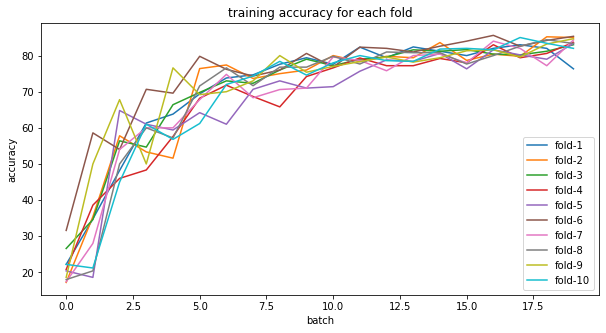

In [ ]:
plot_numerical_arrays(stats, ['fold-'+str(i+1) for i in range(num_folds)], 'batch', 'accuracy', 'training accuracy for each fold')

In [ ]:
min_row = pd.DataFrame.min(scores_df)
min_row['label'] = 'min'
max_row = pd.DataFrame.max(scores_df)
max_row['label'] = 'max'
avg_row = pd.DataFrame.mean(scores_df)
avg_row['label'] = 'avg'
scores_df = scores_df.append(min_row, ignore_index=True)
scores_df = scores_df.append(max_row, ignore_index=True)
scores_df = scores_df.append(avg_row, ignore_index=True)
print(scores_df)

     label  accuracy        f1  recall  precision
0   fold-0      82.0  0.820409   0.820   0.830198
1   fold-1      85.0  0.849421   0.850   0.851845
2   fold-2      78.0  0.780712   0.780   0.783263
3   fold-3      80.5  0.806044   0.805   0.828138
4   fold-4      79.5  0.789999   0.795   0.796173
5   fold-5      83.0  0.832036   0.830   0.844676
6   fold-6      78.0  0.775632   0.780   0.792515
7   fold-7      83.5  0.839352   0.835   0.849791
8   fold-8      77.5  0.778220   0.775   0.798286
9   fold-9      81.0  0.812907   0.810   0.825388
10     min      77.5  0.775632   0.775   0.783263
11     max      85.0  0.849421   0.850   0.851845
12     avg      80.8  0.808473   0.808   0.820027


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """
